<a href="https://colab.research.google.com/github/Jaesu26/aifactory-water-demand-forecasting/blob/main/2022-12-01-%EB%86%8D%EC%B4%8C%EC%A7%80%EC%97%AD-%EC%88%98%EB%8F%97%EB%AC%BC-%EC%88%98%EC%9A%94%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [2022 제2회 K-water AI 경진대회] 수돗물 수요예측 AI 알고리즘 개발

- [2022-Task 2] 아포 : 경상북도 김천시 아포읍

In [1]:
# !pip install xgboost==0.90

## 데이터 불러오기

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import pickle
import random
import math
import os
import gc

import statsmodels.graphics.tsaplots as sgt

from typing import Any, Dict, List, Optional, Tuple, Union
from numpy.typing import NDArray
from easydict import EasyDict

from tqdm.auto import tqdm
from glob import glob

warnings.filterwarnings('ignore') 

In [3]:
from google.colab import drive

drive.mount('/content/drive')  ## 구글코랩과 구글드라이브 연결

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd  /content/drive/MyDrive/Colab Notebooks/농촌지역-수돗물-수요예측

/content/drive/MyDrive/Colab Notebooks/농촌지역-수돗물-수요예측


- 데이터 불러오기

In [5]:
train_path = './data/data_tr_apo.csv'
test_path = './data/data_ts_apo.csv'
submission_path = './data/sample_apo.csv'

In [6]:
df = pd.read_csv(train_path)
test = pd.read_csv(test_path)
submission = pd.read_csv(submission_path)

In [7]:
# 변수 이름을 영문으로 변경
df = df.rename(columns={'구미 아포배수지 유출유량 적산차':'flow'})
test = test.rename(columns={'구미 아포배수지 유출유량 적산차':'flow'})


# 날짜를 datetime 형식으로 변경
df['datetime'] = pd.to_datetime(df['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

- 가중치 저장폴더

In [8]:
def create_folder(path: str) -> None:
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError as error:
        print(error)

- 데이터 설명

`-` 유량: 단위시간 당 얼마만큼의 체적에 해당하는 액체가 이동했는지 나타냄 ($m^3/h$)

`-` 적산값: 1시간마다 측정한 값이 계속 누적 (i.g. $100 \xrightarrow{~+170~} 270 \xrightarrow{~+150~} 420 \xrightarrow{~+110~} 530$)  

`-` 적산차값: 적산의 매시간 차이를 계산 ($\approx$ 시간 단위 공급량,$\quad$ i.g. $\operatorname{NA},170, 150, 110$)

## 전처리

`-` 데이터는 항상 시간상의 순서대로 존재해야 한다

`-` 데이터에서 특정 시점의 적산차값이 결측치일 수도 있지만 특정 시점 자체가 누락되면 안된다 

`-` 그래프에 추세는 없어보인다

`-` 데이터에 결측치가 존재한다

`-` 결측치는 계절성을 고려하여 전날 같은 시각의 적산차값으로 채워주자

`-` 이상치가 존재한다 (예컨대 음수 또는 매우 큰 양수)

`-` 로그 변환

`-` 후처리는 반올림

- 이상치와 결측치 처리

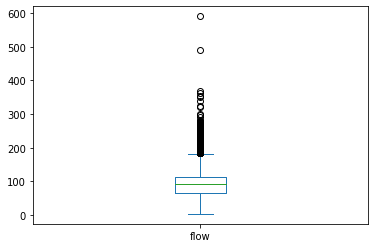

In [ ]:
df.query('0 < flow < 1000').flow.plot.box()

`-` 100,000을 넘기는 매우 큰 값이 존재한다

`-` 또한, 음수값도 존재하는데 이들은 모두 -100,000보다 작다

`-` 위와 같은 경우는 계측기에 문제가 있는 것으로 보인다

`-` 0인 경우도 존재한는데 계측기의 오류 또는 모종의 이유로 물이 흐르지 않은 것으로 보인다 (i.g. 배수지 청소로 인해 단수)

`-` 이런 경우 적산차값만 사용해 예측하는 것은 불가능하므로 이상치로 처리하겠다  

`-` 한편, 큰 양수의 경우 이상치의 기준은 400을 넘지 않는 값 중 최댓값으로 하겠다 (위의 box-plot에 기반함, IQR을 넘는 값들을 보면 400부터 절단되어 빈도수가 매우 작아짐)

`-` 이상치와 결측치는 계절성을 고려하여 전날 같은 시각의 적산차값으로 대체하겠다

In [9]:
def fillna(time_series: pd.Series, m: int = 24) -> pd.Series:
    """m 시점 앞의 값으로 결측치를 재귀적으로 채우고 데이터를 반환"""
    assert time_series.ndim == 1
    time_series = time_series.copy()  # 원본이 변하지 않도록 복제 
    na_idx = time_series[time_series.isnull()].index.values
    fill_idx = na_idx - m  # m 시점 앞의 값으로 결측치를 채운다
    fill_idx = np.where(fill_idx < 0, fill_idx + m, fill_idx)

    if not na_idx.size:                  # 결측치가 존재하지 않으면 원본을 반환
        return time_series
    if np.in1d(fill_idx, na_idx).all():  # m 시점 앞의 값이 결측치면 원본을 반환
        return time_series

    time_series[na_idx] = time_series[fill_idx]
    return fillna(time_series, m)

In [10]:
# 이상치는 결측치로 처리한다
tmp = df.flow[df.flow < 400].max()
df['flow'] = df['flow'].apply(lambda x: x if 0 < x <= tmp else np.nan)

In [11]:
# 결측치는 계절성을 고려하여 전날 같은 시각의 적산차값으로 채운다 
df['flow'] = fillna(df['flow']).fillna(method='ffill').fillna(0)

## 시각화

In [12]:
sns.set_theme(style='white')

In [ ]:
# 연도별 적산차의 분포
df.assign(year = df.datetime.dt.year).\
groupby('year').flow.describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2017,8759.0,94.024775,39.571984,3.0,66.0,89.0,115.0,273.0
2018,8760.0,102.403196,48.363907,4.0,68.0,93.0,113.0,370.0
2019,8760.0,99.048744,48.780636,15.0,63.0,91.0,109.0,340.0
2020,8784.0,101.770947,49.726643,4.0,64.0,94.0,113.0,364.0


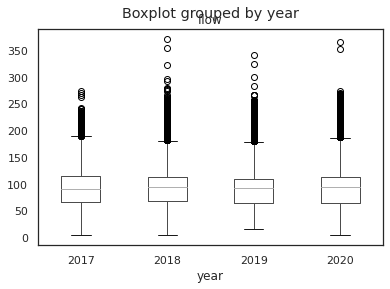

In [ ]:
# 연도별 적산차의 분포
df.assign(year = df.datetime.dt.year).boxplot(column='flow', by='year', grid=False)

`-` 적산차의 경우 2017년과 나머지 연도는 다른 분포를 띄고있다 (평균과 분산이 더 커졌다)

`-` 원인은 200을 넘어가는 큰 값의 빈도수에 있다

`-` 모델 훈련에 2017년 데이터를 사용하지 않는게 미래를 예측하는데 더 나을 수 있다

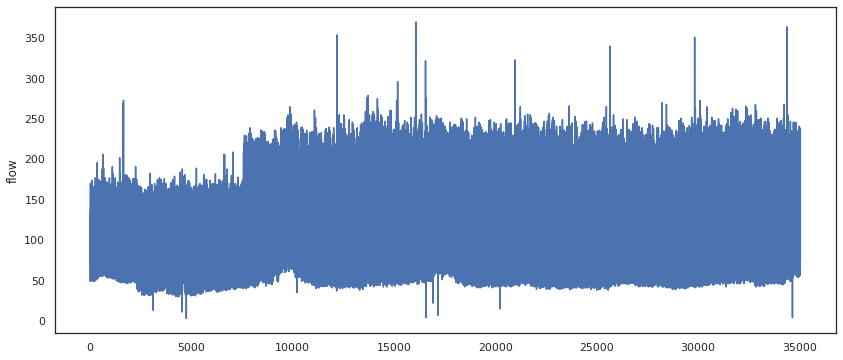

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.lineplot(data=df['flow'], ax=ax)

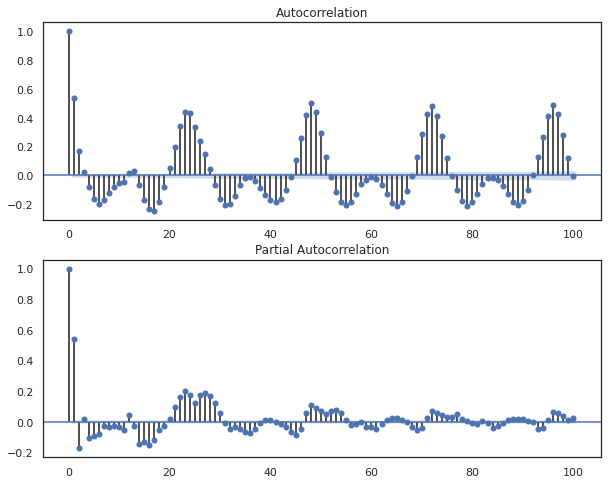

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
sgt.plot_acf(df['flow'], lags = 100, ax=ax1);
sgt.plot_pacf(df['flow'], lags = 100, ax=ax2);

`-` 그래프에 2017년을 제외하면 추세는 존재하지 않고 강한 계절성이 존재한다

`-` ACF, PACF의 정의에 따라 0시점 차이는 의미가 없으므로 무시한다

`-` 계절성이 매우 강하다 (6시간, 18시간, 24시간, 1주, 1달, 1년 등)

`-` 신기한 것은 12시점(12시간)차이의 경우 자기상관이 존재하지 않는다

`-` 사이클(W 모양)이 대략 24시간 마다 반복되므로 최소 24시간 분량의 변수를 모델의 입력으로 사용해야 한다

- 추가 설명

`-`  hello 라는 단어를 생각해보자, 다음의 같은 사이클이 반복된다

`-` h $\to$ e, e $\to$ l, l $\to$ l, l $\to$ o, o $\to$ h 

`-` 만약 단어 하나만이 입력으로 주어진다면 l이 입력으로 들어왔을 때 다음에 오는 단어가 l인지 o인지 알 수 없다

`-` 하지만 연속된 단어 두개가 입력으로 주어진다면 다음에 올 단어를 예측할 수 있다

`-` 예컨대 ll 이면 o, lo 이면 h이다

`-` 이는 적산차를 예측하는 문제에서도 마찬가지이다

## 딥러닝 모델 학습

In [16]:
# !git clone https://github.com/ts-kim/RevIN.git

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler
from torch.nn.modules.loss import _Loss
from torch.optim import Optimizer
from torch.autograd import Variable

import scipy.sparse as sp

import sklearn
from sklearn.multioutput import RegressorChain
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.utils import check_random_state
from sklearn.utils.validation import check_is_fitted
from sklearn.base import clone

import xgboost
from xgboost import XGBRegressor

from RevIN.RevIN import RevIN

- 학습 방법

`-` private 데이터는 2022-01-01-00:00:00 부터 존재할 것이다

`-` public 데이터는 2021-12-17 23:00:00 까지 존재한다

`-` 2021-12-17 23:00:00 에서 337시간 뒤는 2022-01-01 00:00:00 이다

`-` 337시간 후의 적산차를 예측하는 모델을 만드는게 적합하지만 그러면 시간상의 차이가 많이 나서 성능이 떨어진다

`-` 따라서 1시간 후의 적산차를 예측하는 모델을 만들고 존재하지 않는 시각의 정보는 예측한 정보로 대체하여 사용하겠다

`-` 1시간 후의 적산차를 예측하기 위해 pacf 그래프에 근거해 24시간의 배수에 해당하는 분량을 사용하겠다

`-` 사이클을 포함하는(24시간 이상) 시계열 중 24시간 차이가 나는 데이터간의 직접적인 상관관계가 가장 크다

`-` 하나의 사이클을 포함하면서 과적합을 피하기 위해 336시간 분량을 사용하겠다

- 전처리

In [14]:
def ts_train2supervised(
    ts: NDArray[np.float_], 
    window: int = 24,
    gap: int = 1, 
    step: int = 336
) -> Tuple[NDArray[np.float_], NDArray[np.float_]]:
    assert ts.ndim == 2 and ts.shape[1] == 1
    X, y = [], []
    for t in range(len(ts) - (window+gap+step) + 2):
        X.append(ts[t:t+window])
        y.append(ts[t+window+gap-1 : t+window+gap+step-1])
    X, y = np.array(X), np.array(y)  
    return X, y

`-` 예측을 위해 train과 test를 병합 

In [15]:
def ts_test2supervised(
    ts: NDArray[np.float_], 
    window: int = 24
) -> NDArray[np.float_]:
    assert ts.ndim == 2 and ts.shape[1] == 1
    X = []
    for t in range(len(ts) - window + 1):
        X.append(ts[t:t+window])
    X = np.array(X)
    return X

- 난수 고정, gpu 설정

In [17]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # torch.backends.cudnn.enabled = False  # False 이면 재현이 가능하지만 매우 느려지므로 마지막에 사용하자

In [18]:
def clear_gpu() -> None:
    gc.collect()
    torch.cuda.empty_cache()

In [19]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'현재 device는 {DEVICE}입니다')

현재 device는 cuda입니다


- 피쳐 스케일링

`-` 0 ~ 1 사이로 정규화

In [20]:
minmax_scaler = MinMaxScaler()
flow_scaled = minmax_scaler.fit_transform(df['flow'].values.reshape(-1, 1))  
flow_scaled_test = minmax_scaler.transform(test['flow'].values.reshape(-1, 1))   

- 데이터 셋과 데이터 로더

In [21]:
class CustomDataset(Dataset):
    def __init__(self, X: NDArray[np.float_], y: Optional[NDArray[np.float_]] = None) -> None:
        super(CustomDataset, self).__init__()
        self.X = X
        self.y = y

    def __getitem__(self, idx: int) -> Union[Tuple[Tensor, Tensor], Tensor]:
        X = torch.FloatTensor(self.X[idx])
        if self.y is not None:
            y = torch.FloatTensor(self.y[idx])
            return X, y
        return X

    def __len__(self) -> int:
        return self.X.shape[0]

In [22]:
def get_dataloader(
    X: NDArray[np.float_], 
    y: Optional[NDArray[np.float_]] = None, 
    batch_size: int = 64, 
    shuffle: bool = True
) -> DataLoader:
    dataset = CustomDataset(X, y)    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

- early stopping

In [23]:
# ref: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    """주어진 patience 횟수 이후로 validation score가 개선되지 않으면 학습을 조기 중단"""
    mode_dict = {'min':-1, 'max':1}
    score_metrics = [
        'accuracy',
        'f1_score',
        'mae',
    ]

    def __init__(
        self, 
        patience: int = 7, 
        monitor: str = 'loss', 
        mode: str = 'min', 
        min_delta: float = 0.0, 
        folder_path: str = './weights', 
        model_name: str = '',
    ) -> None:
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.direction = self.mode_dict[mode]
        self.monitor = monitor
        self.best_score = -np.Inf
        self.valid_loss = np.Inf
        self.valid_metric_score = None  # 평가지표 (i.g. accuracy)
        self.early_stop = False
        self.min_delta = min_delta
        self.folder_path = folder_path    
        self.model_name = model_name
        self.reset_fold()  # for k-fold cross validation

    def __call__(
        self, 
        model: nn.Module, 
        valid_loss: float, 
        valid_metric_score: Optional[float] = None
    ) -> None:
        # score는 클수록 좋다
        if self.monitor == 'loss':
            score = valid_loss * self.direction
        elif self.monitor in self.score_metrics:
            score = valid_metric_score * self.direction
        else:
            score = None

        # score가 개선되었는지 확인
        if score <= self.best_score + self.min_delta: 
            self.counter += 1 
            if self.counter > self.patience:  # 만약 score가 개선되지 않은 에폭이 patience 횟수보다 크다면 조기 중단
                self.early_stop = True
        else: 
            self.best_score = score 
            self.save_checkpoint(model, valid_loss, valid_metric_score) 
            self.counter = 0  # score가 개선되었으므로 0으로 변경

    def save_checkpoint(
        self, 
        model: nn.Module, 
        valid_loss: float, 
        valid_metric_score: Optional[float] = None
    ) -> None:
        """validation score가 개선되면 모델을 저장"""
        torch.save(model.state_dict(), self.path) 
        self.valid_loss = valid_loss  # 모델이 더 좋게 갱신되었으므로 이때의 valid loss를 기준치로 변경
        self.valid_metric_score = valid_metric_score  # 이때의 valid metric score도 변경

    @property
    def path(self) -> str:
        return f'{self.folder_path}/{self.model_name}_best_{self.fold}.pt'

    def reset_fold(self) -> None:
        self.fold = 0

    def update_fold(self) -> None:
        self.fold += 1

    def reset_score(self) -> None:
        """다음 fold 학습을 위해 score 관련 파라미터를 초기화"""
        self.counter = 0
        self.best_score = -np.Inf
        self.valid_loss = np.Inf
        self.valid_metric_score = None
        self.early_stop = False

- 손실 함수

In [24]:
loss_fn = nn.L1Loss()  # MAE

- 학습 및 검증

In [25]:
def train(
    model: nn.Module,
    dataloader: DataLoader, 
    device: torch.device,
    args: EasyDict,
    loss_fn: _Loss, 
    optimizer: Optimizer, 
    scheduler: Optional[_LRScheduler] = None
) -> Tuple[nn.Module, float]:
    """dataloader의 데이터로 모델을 학습시킨 후 학습된 모델과 평균 배치 훈련 오차를 반환"""  
    train_loss = 0.0
    model.to(device)
    model.train()
    scaler = torch.cuda.amp.GradScaler()

    for X, y in dataloader:  
        X, y = X.to(device), y.to(device) 
        with torch.cuda.amp.autocast():
            y_hat = model(X)
            y_hat = y_hat.squeeze(2)
            loss = loss_fn(y_hat, y)  

        optimizer.zero_grad()  
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=args.max_norm)
        scaler.step(optimizer)
        scaler.update()
        train_loss += (loss.item() / len(dataloader)) 
  
    # 에폭마다 학습률 조절
    if scheduler is not None:
        scheduler.step()
        
    return model, train_loss

In [26]:
def evaluate(
    model: nn.Module, 
    dataloader: DataLoader, 
    device: torch.device,
    args: EasyDict,
    loss_fn: _Loss
) -> Tuple[float, float]:
    """dataloader의 데이터를 모델이 평가한 후 평균 배치 검증 오차와 ACD f1 score를 반환"""
    valid_loss = 0.0
    y_list, yhat_list = np.array([]).reshape(0, args.num_classes), np.array([]).reshape(0, args.num_classes)
    model.to(device)
    model.eval()  

    with torch.no_grad():  
        for X, y in dataloader:  
            X, y = X.to(device), y.to(device) 
            y_hat = model(X)
            y_hat = y_hat.squeeze(2)
            loss = loss_fn(y_hat, y)  
            y = y.detach().cpu().numpy()  # y shape: (B, 336)
            y_hat = y_hat.detach().cpu().numpy()  # yhat shape: (B, 336)
            y_list = np.concatenate([y_list, minmax_scaler.inverse_transform(y)])
            yhat_list = np.concatenate([yhat_list, minmax_scaler.inverse_transform(y_hat)])
            valid_loss += (loss.item() / len(dataloader))

    valid_mae = mean_absolute_error(y_list, yhat_list)        
    return valid_loss, valid_mae

In [27]:
def holdout_validate(
    model: nn.Module, 
    X_train: NDArray[np.float_],
    y_train: NDArray[np.float_],
    X_val: NDArray[np.float_],
    y_val: NDArray[np.float_],
    loss_fn: _Loss, 
    early_stopping: EarlyStopping,
    device: torch.device,
    args: EasyDict 
) -> Tuple[nn.Module, List[List[float]], List[List[float]]]:
    """K겹 교차검증을 통해 모델의 성능을 평가하고 학습된 모델과 폴드별 훈련 손실, 검증 손실을 반환"""
    seed_everything(args.seed)  # 정확한 재현을 위함
    fold_valid_loss = []   # 폴드별 best 검증 손실
    fold_train_losses_per_epoch = [[]]  # 폴드별 1 에폭에 따른 훈련 배치 손실
    fold_valid_losses_per_epoch = [[]]  # 폴드별 1 에폭에 따른 검증 배치 손실
    early_stopping.reset_fold()  # fold 초기화

    print(f'[1 / 1] Fold Training......')

    # 메모리 절약
    clear_gpu()

    # Dataloader
    train_dataloader = get_dataloader(X_train, y_train, args.bs)
    valid_dataloader = get_dataloader(X_val, y_val, args.bs, shuffle=False)

    # optimizer
    optimizer = optim.AdamW(model.parameters(), lr=args.lr, weight_decay=args.weight_decay) 

    # scheduler
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    # early stopping, 다음 폴드 학습을 위해 score 관련 파라미터 초기화
    early_stopping.reset_score()
    early_stopping.update_fold()  
    
    # 폴드마다 모델 학습
    for epoch in tqdm(range(1, args.num_epochs+1)):  # (배치사이즈 X 에폭) 만큼 훈련시킴           
        model, train_loss = train(model, train_dataloader, device, args, loss_fn, optimizer, scheduler)  # 모델 학습
        valid_loss, valid_mae = evaluate(model, valid_dataloader, device, args, loss_fn)  # 모델 평가
        fold_train_losses_per_epoch[0].append(train_loss) 
        fold_valid_losses_per_epoch[0].append(valid_loss)  

        print_score_condition = (epoch == 1 or epoch % 5 == 0 or epoch == args.num_epochs)  
        score_information = f'[Epoch: {epoch:>2}]  train loss = {train_loss:.5f}  valid loss = {valid_loss:.5f}  valid MAE = {valid_mae:.5f}'

        # 평균 배치 훈련 오차와 검증 오차 출력
        if print_score_condition:  
            print(score_information)  
            
        # 에폭마다 early stopping 실행
        early_stopping(model, valid_loss, valid_mae)  
        if early_stopping.early_stop: 
            if not print_score_condition:  # 이미 출력한 에폭에 대해 중복으로 출력하지 않기 위함
                print(score_information) 
            print('Early Stopping!')
            break 

    fold_valid_loss.append(early_stopping.valid_loss)  # 폴드별 best 검증 손실
      
    # 폴드별 학습 및 검증 종료시 best 검증 손실을 출력
    print(f'1 Fold -> Valid Loss: {early_stopping.valid_loss:.5f}  Valid MAE: {early_stopping.valid_metric_score:.5f}')
    return model, fold_train_losses_per_epoch, fold_valid_losses_per_epoch

- 에폭에 따른 손실의 변화

In [28]:
def show_loss_plot(
    fold_train_losses: List[List[float]],
    fold_valid_losses: List[List[float]]
) -> None:
    """폴드별로 에폭에 따른 모델의 훈련 손실과 검증 손실의 변화를 시각화"""
    assert len(fold_train_losses) == len(fold_valid_losses)
    num_folds = len(fold_train_losses)
    ncols = 3
    nrows = 1 + (num_folds - 1)//ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4)) 

    # 폴드마다 에폭에 따른 훈련 손실과 검증 손실의 변화를 시각화
    for fold, (ax, train_losses, valid_losses) in enumerate(zip(axes.flatten(), fold_train_losses, fold_valid_losses), start=1):
        assert len(train_losses) == len(valid_losses) 
        if fold > num_folds:
            break

        num_epochs = len(train_losses)
        ax.set_title(f'{fold} Fold')
        ax.plot(range(1, num_epochs+1), train_losses, label='Train')
        ax.plot(range(1, num_epochs+1), valid_losses, label='Valid')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()

    fig.suptitle('Train Loss and Valid Loss', x=0.51, y=1.05, fontsize=15)
    fig.tight_layout()

    # 남는 서브 플랏 제거
    for ax in axes.flatten():
        if not ax.has_data():
            fig.delaxes(ax)

- Test 예측

In [29]:
def predict(
    model: nn.Module, 
    X: NDArray[np.float_],
    device: torch.device,
    args: EasyDict
) -> Tensor:   
    weight_paths = glob(args.weight_folder_path + '/*.pt')
    dataloader = get_dataloader(X, shuffle=False)
    test_preds = torch.zeros(len(dataloader.dataset), args.num_classes)  
    num_folds = len([weight_path for weight_path in weight_paths if args.model_name in weight_path])
     
    for weight_path in tqdm(weight_paths):
        if args.model_name not in weight_path:
            continue
            
        preds = np.array([]).reshape(0, args.num_classes)
        model.load_state_dict(torch.load(weight_path, map_location=device))
        model.to(device)
        model.eval()

        with torch.no_grad(): 
            for X in dataloader:  # test 데이터는 라벨(y)이 없다
                X = X.to(device)  # shape of X: (Batch, Sequence, Feature)
                y_hat = model(X).detach().cpu().squeeze(2).numpy()  # shape of yhat: (Batch, Class)
                preds = np.concatenate([preds, y_hat]) 

        test_preds += (preds / num_folds) 
    return test_preds     

- 후처리

`-` 훈련 데이터를 보면 적산차값이 모두 정수형이다

`-` 예측값도 반올림하여 정수로 만들어주겠다

`-` 최솟값과 최댓값을 제한

In [44]:
MAX = df['flow'].values.max()
MIN = df['flow'].values.min()

In [49]:
def postprocessing(pred: NDArray[np.float_], minimum: float, maximum: float) -> NDArray[np.float_]:
    pred = np.clip(pred, minimum, maximum)
    pred = np.round(pred)
    return pred

### LSTM 모델 학습

#### 모델 학습 준비

`-` 96개의 데이터를 사용

In [126]:
lstm_args = EasyDict({
    'weight_folder_path':'./weights',
    'model_name':'lstm',
    'window':96,
    'gap':1,
    'num_classes':336,
    'num_epochs':60,
    'bs':64,
    'lr':2e-4,
    'weight_decay':1e-2,
    'max_norm':1.0,
    'seed':22,
})

In [127]:
create_folder(lstm_args.weight_folder_path)

- 데이터 생성

In [128]:
Xs, ys = ts_train2supervised(flow_scaled, window=lstm_args.window, gap=lstm_args.gap, step=lstm_args.num_classes)  # s == scaled
ys = ys.squeeze(2)

In [129]:
# 8:2로 분할 (9:1로 분할하면 성능이 MAE 기준 0.02 더 낫지만 속도와 모델의 견고성 측면에서 8:2로 분할하겠다)
Xs_train, ys_train = Xs[:-(Xs.shape[0]//5)], ys[:-(ys.shape[0]//5)] 
Xs_val, ys_val = Xs[-(Xs.shape[0]//5):], ys[-(ys.shape[0]//5):]

#### 모델 학습 및 검증

In [130]:
# 참고: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
# 참고할 것: https://teddylee777.github.io/pytorch/pytorch-rnn
# input of shape (batch, sequence, feature(=input size)) 
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=256, num_layers=4, num_classes=336, dropout_prob=0.1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.revin_layer = RevIN(input_size)  # 시간에 따라 변하는 시계열의 평균과 분산을 스케일링

    def forward(self, x):  # shape of x: (Batch, Sequence, Feature)
        # x shape: (B, 96(=sequence), input_size)
        x = self.revin_layer(x, 'norm')
        # x shape: (B, 96, input_size)
        x, _ = self.lstm(x)  # h_0, c_0 기본값은 0으로 채워진 텐서
        # x shape: (B, 96, hidden_size)
        x = self.fc(x[:,-1,:])  
        # x shape: (B, num_classes)
        x = x.unsqueeze(2)
        # x shape: (B, num_classes, input_size)
        x = self.revin_layer(x, 'denorm')
        # x shape: (B, num_classes, input_size)
        return x

In [131]:
early_stopping = EarlyStopping(patience=10,
                               monitor='mae',
                               mode='min',
                               folder_path=lstm_args.weight_folder_path,
                               model_name=lstm_args.model_name)

In [132]:
seed_everything(lstm_args.seed)
model = LSTMModel(input_size=1, hidden_size=256, num_layers=4, num_classes=lstm_args.num_classes, dropout_prob=0.1).to(DEVICE)

In [133]:
model, fold_train_losses_per_epoch, fold_valid_losses_per_epoch = holdout_validate(model, Xs_train, ys_train, Xs_val, ys_val,
                                                                                   loss_fn, early_stopping, DEVICE, lstm_args)

[1 / 1] Fold Training......


  0%|          | 0/60 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.06861  valid loss = 0.06298  valid MAE = 23.11774
[Epoch:  5]  train loss = 0.05982  valid loss = 0.06241  valid MAE = 22.90741
[Epoch: 10]  train loss = 0.05724  valid loss = 0.06208  valid MAE = 22.78784
[Epoch: 15]  train loss = 0.05260  valid loss = 0.06123  valid MAE = 22.47117
[Epoch: 20]  train loss = 0.05190  valid loss = 0.06089  valid MAE = 22.35006
[Epoch: 25]  train loss = 0.05145  valid loss = 0.06067  valid MAE = 22.26956
[Epoch: 30]  train loss = 0.05112  valid loss = 0.06075  valid MAE = 22.30070
[Epoch: 35]  train loss = 0.05084  valid loss = 0.06065  valid MAE = 22.26374
[Epoch: 40]  train loss = 0.05065  valid loss = 0.06055  valid MAE = 22.22520
[Epoch: 45]  train loss = 0.05048  valid loss = 0.06050  valid MAE = 22.20951
[Epoch: 50]  train loss = 0.05037  valid loss = 0.06069  valid MAE = 22.28236
[Epoch: 55]  train loss = 0.05026  valid loss = 0.06051  valid MAE = 22.21602
[Epoch: 58]  train loss = 0.05023  valid loss = 0.06053  valid M

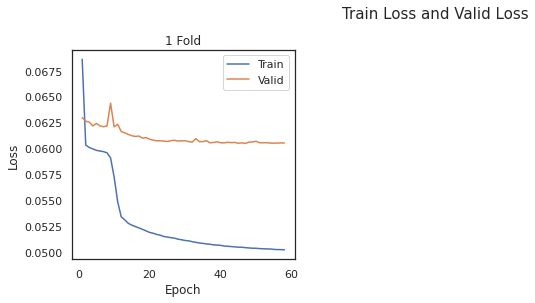

In [134]:
show_loss_plot(fold_train_losses_per_epoch, fold_valid_losses_per_epoch)

#### Test 예측

In [135]:
flow_scaled_all = np.concatenate([flow_scaled[-lstm_args.window:], flow_scaled_test])  # train + test
Xs_test = ts_test2supervised(flow_scaled_all, window=lstm_args.window)   

In [136]:
preds = predict(model, Xs_test, DEVICE, lstm_args)

  0%|          | 0/4 [00:00<?, ?it/s]

In [139]:
preds = minmax_scaler.inverse_transform(preds)
submission.loc[:, 'h0':'h335'] = postprocessing(preds, MIN, MAX)
submission.to_csv(f'./data/submission_apo_{lstm_args.model_name}.csv', index=False)

- 성능 확인

In [138]:
tmp = test.copy()
for w in range(1, 336):
    tmp[f'flow{w}'] = tmp['flow'].shift(-w)

y_hat = submission.loc[:, 'h0':'h335'].to_numpy()[:8089]
tmp = tmp.dropna().loc[:, 'flow':'flow335'].to_numpy()
mean_absolute_error(tmp, y_hat)

22.328050953970415

### SCI Net 모델 학습

#### 모델 학습 준비

In [140]:
sci_args = EasyDict({
    'weight_folder_path':'./weights',
    'model_name':'sci',
    'window':336,
    'gap':1,
    'num_classes':336,
    'num_epochs':60,
    'bs':64,
    'lr':2e-4,
    'weight_decay':1e-2,
    'max_norm':1.0,
    'seed':22,
})

In [141]:
Xs, ys = ts_train2supervised(flow_scaled, window=sci_args.window, gap=sci_args.gap, step=sci_args.num_classes)  # s == scaled
ys = ys.squeeze(2)

Xs_train, ys_train = Xs[:-(Xs.shape[0]//5)], ys[:-(ys.shape[0]//5)] 
Xs_val, ys_val = Xs[-(Xs.shape[0]//5):], ys[-(ys.shape[0]//5):]

In [142]:
early_stopping = EarlyStopping(patience=10,
                               monitor='mae',
                               mode='min',
                               folder_path=sci_args.weight_folder_path,
                               model_name=sci_args.model_name)

In [143]:
# https://github.com/ts-kim/RevIN/blob/master/baselines/SCINet/models/SCINet.py
# Copyright (c) 2022 Electronics and Telecommunications Research Institute (ETRI) 
class Splitting(nn.Module):
    def __init__(self):
        super(Splitting, self).__init__()

    def even(self, x):
        return x[:, ::2, :]

    def odd(self, x):
        return x[:, 1::2, :]

    def forward(self, x):
        """Returns the odd and even part"""
        return (self.even(x), self.odd(x))


class Interactor(nn.Module):
    def __init__(self, in_planes, splitting=True,
                 kernel=5, dropout=0.5, groups=1, hidden_size=1, INN=True):
        super(Interactor, self).__init__()
        self.modified = INN
        self.kernel_size = kernel
        self.dilation = 1
        self.dropout = dropout
        self.hidden_size = hidden_size
        self.groups = groups

        if self.kernel_size % 2 == 0:
            pad_l = self.dilation * (self.kernel_size - 2) // 2 + 1  # by default: stride==1 
            pad_r = self.dilation * (self.kernel_size) // 2 + 1  # by default: stride==1 
        else:
            pad_l = self.dilation * (self.kernel_size - 1) // 2 + 1  # we fix the kernel size of the second layer as 3.
            pad_r = self.dilation * (self.kernel_size - 1) // 2 + 1

        self.splitting = splitting
        self.split = Splitting()

        modules_P = []
        modules_U = []
        modules_psi = []
        modules_phi = []
        prev_size = 1

        size_hidden = self.hidden_size
        modules_P += [
            nn.ReplicationPad1d((pad_l, pad_r)),

            nn.Conv1d(in_planes * prev_size, int(in_planes * size_hidden),
                      kernel_size=self.kernel_size, dilation=self.dilation, stride=1, groups=self.groups),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),

            nn.Dropout(self.dropout),
            nn.Conv1d(int(in_planes * size_hidden), in_planes,
                      kernel_size=3, stride=1, groups=self.groups),
            nn.Tanh()
        ]
        modules_U += [
            nn.ReplicationPad1d((pad_l, pad_r)),
            nn.Conv1d(in_planes * prev_size, int(in_planes * size_hidden),
                      kernel_size=self.kernel_size, dilation=self.dilation, stride=1, groups=self.groups),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(self.dropout),
            nn.Conv1d(int(in_planes * size_hidden), in_planes,
                      kernel_size=3, stride=1, groups=self.groups),
            nn.Tanh()
        ]

        modules_phi += [
            nn.ReplicationPad1d((pad_l, pad_r)),
            nn.Conv1d(in_planes * prev_size, int(in_planes * size_hidden),
                      kernel_size=self.kernel_size, dilation=self.dilation, stride=1, groups=self.groups),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(self.dropout),
            nn.Conv1d(int(in_planes * size_hidden), in_planes,
                      kernel_size=3, stride=1, groups=self.groups),
            nn.Tanh()
        ]
        modules_psi += [
            nn.ReplicationPad1d((pad_l, pad_r)),
            nn.Conv1d(in_planes * prev_size, int(in_planes * size_hidden),
                      kernel_size=self.kernel_size, dilation=self.dilation, stride=1, groups=self.groups),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(self.dropout),
            nn.Conv1d(int(in_planes * size_hidden), in_planes,
                      kernel_size=3, stride=1, groups=self.groups),
            nn.Tanh()
        ]
        self.phi = nn.Sequential(*modules_phi)
        self.psi = nn.Sequential(*modules_psi)
        self.P = nn.Sequential(*modules_P)
        self.U = nn.Sequential(*modules_U)

    def forward(self, x):
        if self.splitting:
            (x_even, x_odd) = self.split(x)
        else:
            (x_even, x_odd) = x

        if self.modified:
            x_even = x_even.permute(0, 2, 1)
            x_odd = x_odd.permute(0, 2, 1)

            d = x_odd.mul(torch.exp(self.phi(x_even)))
            c = x_even.mul(torch.exp(self.psi(x_odd)))

            x_even_update = c + self.U(d)
            x_odd_update = d - self.P(c)
            return (x_even_update, x_odd_update)
        else:
            x_even = x_even.permute(0, 2, 1)
            x_odd = x_odd.permute(0, 2, 1)

            d = x_odd - self.P(x_even)
            c = x_even + self.U(d)
            return (c, d)


class InteractorLevel(nn.Module):
    def __init__(self, in_planes, kernel, dropout, groups , hidden_size, INN):
        super(InteractorLevel, self).__init__()
        self.level = Interactor(in_planes=in_planes, splitting=True,
                 kernel=kernel, dropout=dropout, groups=groups, hidden_size=hidden_size, INN=INN)

    def forward(self, x):
        (x_even_update, x_odd_update) = self.level(x)
        return (x_even_update, x_odd_update)

class LevelSCINet(nn.Module):
    def __init__(self,in_planes, kernel_size, dropout, groups, hidden_size, INN):
        super(LevelSCINet, self).__init__()
        self.interact = InteractorLevel(in_planes=in_planes, kernel=kernel_size, dropout=dropout, groups=groups , hidden_size=hidden_size, INN=INN)

    def forward(self, x):
        (x_even_update, x_odd_update) = self.interact(x)
        return x_even_update.permute(0, 2, 1), x_odd_update.permute(0, 2, 1) #even: B, T, D odd: B, T, D

class SCINet_Tree(nn.Module):
    def __init__(self, in_planes, current_level, kernel_size, dropout, groups, hidden_size, INN):
        super().__init__()
        self.current_level = current_level

        self.workingblock = LevelSCINet(
            in_planes=in_planes,
            kernel_size=kernel_size,
            dropout=dropout,
            groups=groups,
            hidden_size=hidden_size,
            INN=INN)

        if current_level != 0:
            self.SCINet_Tree_odd=SCINet_Tree(in_planes, current_level-1, kernel_size, dropout, groups, hidden_size, INN)
            self.SCINet_Tree_even=SCINet_Tree(in_planes, current_level-1, kernel_size, dropout, groups, hidden_size, INN)
    
    def zip_up_the_pants(self, even, odd):
        even = even.permute(1, 0, 2)
        odd = odd.permute(1, 0, 2)  # L, B, D
        even_len = even.shape[0]
        odd_len = odd.shape[0]
        mlen = min((odd_len, even_len))
        _ = []
        for i in range(mlen):
            _.append(even[i].unsqueeze(0))
            _.append(odd[i].unsqueeze(0))
        if odd_len < even_len: 
            _.append(even[-1].unsqueeze(0))
        return torch.cat(_, 0).permute(1, 0, 2)  # B, L, D
        
    def forward(self, x):
        x_even_update, x_odd_update = self.workingblock(x)
        # We recursively reordered these sub-series. You can run the ./utils/recursive_demo.py to emulate this procedure. 
        if self.current_level == 0:
            return self.zip_up_the_pants(x_even_update, x_odd_update)
        else:
            return self.zip_up_the_pants(self.SCINet_Tree_even(x_even_update), self.SCINet_Tree_odd(x_odd_update))

class EncoderTree(nn.Module):
    def __init__(self, in_planes,  num_levels, kernel_size, dropout, groups, hidden_size, INN):
        super().__init__()
        self.levels=num_levels
        self.SCINet_Tree=SCINet_Tree(
            in_planes=in_planes,
            current_level=num_levels-1,
            kernel_size=kernel_size,
            dropout=dropout ,
            groups=groups,
            hidden_size=hidden_size,
            INN=INN)
        
    def forward(self, x):
        x = self.SCINet_Tree(x)
        return x

class SCINet(nn.Module):
    def __init__(self, output_len, input_len, input_dim=1, hid_size=1, num_stacks=1,
                num_levels=3, concat_len=0, groups=1, kernel=5, dropout=0.5,
                 single_step_output_One=0, input_len_seg=0, positionalE=False, modified=True):
        super(SCINet, self).__init__()
        self.input_dim = input_dim
        self.input_len = input_len
        self.output_len = output_len
        self.hidden_size = hid_size
        self.num_levels = num_levels
        self.groups = groups
        self.modified = modified
        self.kernel_size = kernel
        self.dropout = dropout
        self.single_step_output_One = single_step_output_One
        self.concat_len = concat_len
        self.pe = positionalE
        self.revin = RevIN(input_dim)  # b, s, f means b, f

        self.blocks1 = EncoderTree(
            in_planes=self.input_dim,
            num_levels=self.num_levels,
            kernel_size=self.kernel_size,
            dropout=self.dropout,
            groups=self.groups,
            hidden_size=self.hidden_size,
            INN=modified)

        if num_stacks == 2: # we only implement two stacks at most.
            self.blocks2 = EncoderTree(
                in_planes=self.input_dim,
                num_levels=self.num_levels,
                kernel_size=self.kernel_size,
                dropout=self.dropout,
                groups=self.groups,
                hidden_size=self.hidden_size,
                INN=modified)

        self.stacks = num_stacks

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
        self.projection1 = nn.Conv1d(self.input_len, self.output_len, kernel_size=1, stride=1, bias=False)
        
        if self.single_step_output_One:  # only output the N_th timestep.
            if self.stacks == 2:
                if self.concat_len:
                    self.projection2 = nn.Conv1d(self.concat_len + self.output_len, 1,
                                                kernel_size = 1, bias = False)
                else:
                    self.projection2 = nn.Conv1d(self.input_len + self.output_len, 1,
                                                kernel_size = 1, bias = False)
        else: # output the N timesteps.
            if self.stacks == 2:
                if self.concat_len:
                    self.projection2 = nn.Conv1d(self.concat_len + self.output_len, self.output_len,
                                                kernel_size = 1, bias = False)
                else:
                    self.projection2 = nn.Conv1d(self.input_len + self.output_len, self.output_len,
                                                kernel_size = 1, bias = False)

        # For positional encoding
        self.pe_hidden_size = input_dim
        if self.pe_hidden_size % 2 == 1:
            self.pe_hidden_size += 1
    
        num_timescales = self.pe_hidden_size // 2
        max_timescale = 10000.0
        min_timescale = 1.0

        log_timescale_increment = (
                math.log(float(max_timescale) / float(min_timescale)) /
                max(num_timescales - 1, 1))
        temp = torch.arange(num_timescales, dtype=torch.float32)
        inv_timescales = min_timescale * torch.exp(
            torch.arange(num_timescales, dtype=torch.float32) *
            -log_timescale_increment)
        self.register_buffer('inv_timescales', inv_timescales)
    
    def get_position_encoding(self, x):
        max_length = x.size()[1]
        position = torch.arange(max_length, dtype=torch.float32, device=x.device)  # tensor([0., 1., 2., 3., 4.], device='cuda:0')
        temp1 = position.unsqueeze(1)  # 5 1
        temp2 = self.inv_timescales.unsqueeze(0)  # 1 256
        scaled_time = position.unsqueeze(1) * self.inv_timescales.unsqueeze(0)  # 5 256
        signal = torch.cat([torch.sin(scaled_time), torch.cos(scaled_time)], dim=1)  # [T, C]
        signal = F.pad(signal, (0, 0, 0, self.pe_hidden_size % 2))
        signal = signal.view(1, max_length, self.pe_hidden_size)
        return signal

    def forward(self, x):
        assert self.input_len % (np.power(2, self.num_levels)) == 0  # evenly divided the input length into two parts. (e.g., 32 -> 16 -> 8 -> 4 for 3 levels)
        x = self.revin(x, 'norm')

        if self.pe:
            pe = self.get_position_encoding(x)
            if pe.shape[2] > x.shape[2]:
                x += pe[:, :, :-1]
            else:
                x += self.get_position_encoding(x)
        # the first stack
        res1 = x
        x = self.blocks1(x)
        x += res1
        x = self.projection1(x)

        if self.stacks == 1:
            x = self.revin(x,'denorm')
            return x  # maybe forecast
        elif self.stacks == 2:
            MidOutPut = x  # maybe forecast
            if self.concat_len:
                x = torch.cat((res1[:, -self.concat_len:,:], x), dim=1)
            else:
                x = torch.cat((res1, x), dim=1)

            # the second stack
            res2 = x
            x = self.blocks2(x)
            x += res2
            x = self.projection2(x)
            MidOutPut = self.revin(MidOutPut, 'denorm')
            x = self.revin(x, 'denorm')
            return x, MidOutPut


def get_variable(x):
    x = Variable(x)
    return x.cuda() if torch.cuda.is_available() else x

#### 모델 학습 및 검증

In [148]:
seed_everything(sci_args.seed)
model = SCINet(output_len=sci_args.num_classes, input_len=sci_args.window, input_dim=1, hid_size=1, num_stacks=1,
               num_levels=3, concat_len=0, groups=1, kernel=7, dropout=0.5,
               single_step_output_One=0, positionalE=True, modified=True).to(DEVICE)

In [149]:
model, fold_train_losses_per_epoch, fold_valid_losses_per_epoch = holdout_validate(model, Xs_train, ys_train, Xs_val, ys_val,
                                                                                   loss_fn, early_stopping, DEVICE, sci_args)

[1 / 1] Fold Training......


  0%|          | 0/60 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.09729  valid loss = 0.08652  valid MAE = 31.75527
[Epoch:  5]  train loss = 0.05613  valid loss = 0.06440  valid MAE = 23.64317
[Epoch: 10]  train loss = 0.05484  valid loss = 0.06311  valid MAE = 23.16840
[Epoch: 15]  train loss = 0.05423  valid loss = 0.06292  valid MAE = 23.09949
[Epoch: 20]  train loss = 0.05375  valid loss = 0.06265  valid MAE = 22.99851
[Epoch: 25]  train loss = 0.05356  valid loss = 0.06248  valid MAE = 22.93416
[Epoch: 30]  train loss = 0.05343  valid loss = 0.06245  valid MAE = 22.92314
[Epoch: 35]  train loss = 0.05335  valid loss = 0.06241  valid MAE = 22.90994
[Epoch: 40]  train loss = 0.05330  valid loss = 0.06237  valid MAE = 22.89550
[Epoch: 45]  train loss = 0.05325  valid loss = 0.06238  valid MAE = 22.89989
[Epoch: 50]  train loss = 0.05321  valid loss = 0.06235  valid MAE = 22.88701
[Epoch: 55]  train loss = 0.05319  valid loss = 0.06235  valid MAE = 22.88950
[Epoch: 60]  train loss = 0.05317  valid loss = 0.06233  valid M

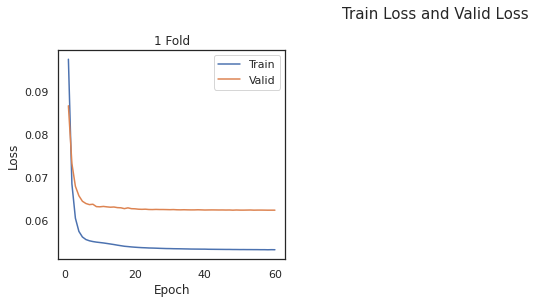

In [155]:
show_loss_plot(fold_train_losses_per_epoch, fold_valid_losses_per_epoch)

#### Test 예측

In [151]:
flow_scaled_all = np.concatenate([flow_scaled[-sci_args.window:], flow_scaled_test])  # train + test
Xs_test = ts_test2supervised(flow_scaled_all, window=sci_args.window)   

In [152]:
preds = predict(model, Xs_test, DEVICE, sci_args)

  0%|          | 0/4 [00:00<?, ?it/s]

In [153]:
preds = minmax_scaler.inverse_transform(preds)
submission.loc[:, 'h0':'h335'] = postprocessing(preds, MIN, MAX)
submission.to_csv(f'./data/submission_apo_{sci_args.model_name}.csv', index=False)

- 성능 확인

In [154]:
tmp = test.copy()
for w in range(1, 336):
    tmp[f'flow{w}'] = tmp['flow'].shift(-w)

y_hat = submission.loc[:, 'h0':'h335'].to_numpy()[:8089]
tmp = tmp.dropna().loc[:, 'flow':'flow335'].to_numpy()
mean_absolute_error(tmp, y_hat)

22.83634079790898

### DLinear 모델 학습

#### 모델 학습 준비

In [31]:
dlinear_args = EasyDict({
    'weight_folder_path':'./weights',
    'model_name':'dlinear',
    'window':336,
    'gap':1,
    'num_classes':336,
    'num_epochs':100,
    'bs':64,
    'lr':2e-4,
    'weight_decay':1e-2,
    'max_norm':1.0,
    'seed':22,
    'seq_len':336,
    'pred_len':336,
    'enc_in':1,
    'individual':False,
})

In [110]:
create_folder(dlinear_args.weight_folder_path)

In [32]:
Xs, ys = ts_train2supervised(flow_scaled, window=dlinear_args.window, gap=dlinear_args.gap, step=dlinear_args.num_classes)  # s == scaled
ys = ys.squeeze(2)

Xs_train, ys_train = Xs[:-(Xs.shape[0]//5)], ys[:-(ys.shape[0]//5)] 
Xs_val, ys_val = Xs[-(Xs.shape[0]//5):], ys[-(ys.shape[0]//5):]

In [33]:
early_stopping = EarlyStopping(patience=10,
                               monitor='mae',
                               mode='min',
                               folder_path=dlinear_args.weight_folder_path,
                               model_name=dlinear_args.model_name)

In [34]:
# ref: https://github.com/cure-lab/LTSF-Linear/blob/main/models/DLinear.py
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class DLinear(nn.Module):
    """
    Decomposition-Linear
    """
    def __init__(self, configs):
        super(DLinear, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.revin_layer = RevIN(configs.enc_in)  # 시간에 따라 변하는 시계열의 평균과 분산을 스케일링

        # Decompsition Kernel Size
        kernel_size = 25
        self.decompsition = series_decomp(kernel_size)
        self.individual = configs.individual
        self.channels = configs.enc_in

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend = nn.ModuleList()
            
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len, self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len, self.pred_len))

                # Use this two lines if you want to visualize the weights
                # self.Linear_Seasonal[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len, self.seq_len]))
                # self.Linear_Trend[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len, self.seq_len]))
        else:
            self.Linear_Seasonal = nn.Linear(self.seq_len, self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len, self.pred_len)
            
            # Use this two lines if you want to visualize the weights
            # self.Linear_Seasonal.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
            # self.Linear_Trend.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))

    def forward(self, x):
        x = self.revin_layer(x, 'norm')
        # x: [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1)
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len], dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),self.pred_len],dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        x = self.revin_layer(x, 'denorm')
        return x.permute(0,2,1) # to [Batch, Output length, Channel]

#### 모델 학습 및 검증

In [73]:
seed_everything(dlinear_args.seed)
model = DLinear(dlinear_args)

In [36]:
model, fold_train_losses_per_epoch, fold_valid_losses_per_epoch = holdout_validate(model, Xs_train, ys_train, Xs_val, ys_val,
                                                                                   loss_fn, early_stopping, DEVICE, dlinear_args)

[1 / 1] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.07073  valid loss = 0.07363  valid MAE = 27.02671
[Epoch:  5]  train loss = 0.05517  valid loss = 0.06364  valid MAE = 23.35989
[Epoch: 10]  train loss = 0.05466  valid loss = 0.06318  valid MAE = 23.19350
[Epoch: 15]  train loss = 0.05457  valid loss = 0.06308  valid MAE = 23.15575
[Epoch: 20]  train loss = 0.05453  valid loss = 0.06311  valid MAE = 23.16580
[Epoch: 25]  train loss = 0.05449  valid loss = 0.06300  valid MAE = 23.12762
[Epoch: 30]  train loss = 0.05446  valid loss = 0.06302  valid MAE = 23.13357
[Epoch: 33]  train loss = 0.05445  valid loss = 0.06298  valid MAE = 23.11891
Early Stopping!
1 Fold -> Valid Loss: 0.06296  Valid MAE: 23.11163


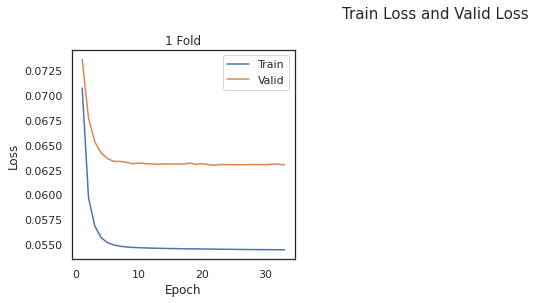

In [40]:
show_loss_plot(fold_train_losses_per_epoch, fold_valid_losses_per_epoch)

#### Test 예측

In [77]:
flow_scaled_all = np.concatenate([flow_scaled[-dlinear_args.window:], flow_scaled_test])  # train + test
Xs_test = ts_test2supervised(flow_scaled_all, window=dlinear_args.window)   

In [78]:
preds = predict(model, Xs_test, DEVICE, dlinear_args)

  0%|          | 0/4 [00:00<?, ?it/s]

In [79]:
preds = minmax_scaler.inverse_transform(preds)
submission.loc[:, 'h0':'h335'] = postprocessing(preds, MIN, MAX)
submission.to_csv(f'./data/submission_apo_{dlinear_args.model_name}.csv', index=False)

- 성능 확인

In [81]:
tmp = test.copy()
for w in range(1, 336):
    tmp[f'flow{w}'] = tmp['flow'].shift(-w)

y_hat = submission.loc[:, 'h0':'h335'].to_numpy()[:8089]
tmp = tmp.dropna().loc[:, 'flow':'flow335'].to_numpy()
mean_absolute_error(tmp, y_hat)

22.89605961064114

### NLinear 모델 학습


#### 모델 학습 준비

In [59]:
nlinear_args = EasyDict({
    'weight_folder_path':'./weights',
    'model_name':'nlinear',
    'window':336,
    'gap':1,
    'num_classes':336,
    'num_epochs':60,
    'bs':64,
    'lr':2e-4,
    'weight_decay':1e-2,
    'max_norm':1.0,
    'seed':22,
    'seq_len':336,
    'pred_len':336,
    'enc_in':1,
    'individual':False,
})

In [111]:
create_folder(nlinear_args.weight_folder_path)

In [60]:
Xs, ys = ts_train2supervised(flow_scaled, window=nlinear_args.window, gap=nlinear_args.gap, step=nlinear_args.num_classes)  # s == scaled
ys = ys.squeeze(2)

Xs_train, ys_train = Xs[:-(Xs.shape[0]//5)], ys[:-(ys.shape[0]//5)] 
Xs_val, ys_val = Xs[-(Xs.shape[0]//5):], ys[-(ys.shape[0]//5):]

In [61]:
early_stopping = EarlyStopping(patience=10,
                               monitor='mae',
                               mode='min',
                               folder_path=nlinear_args.weight_folder_path,
                               model_name=nlinear_args.model_name)

In [101]:
class NLinear(nn.Module):
    """
    Normalization-Linear
    """
    def __init__(self, configs):
        super(NLinear, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.Linear = nn.Linear(self.seq_len, self.pred_len)
        self.revin_layer = RevIN(configs.enc_in)  # 시간에 따라 변하는 시계열의 평균과 분산을 스케일링
        # Use this line if you want to visualize the weights
        # self.Linear.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))

    def forward(self, x):
        x = self.revin_layer(x, 'norm')
        # x: [Batch, Input length, Channel]
        seq_last = x[:,-1:,:].detach()
        x = x - seq_last
        x = self.Linear(x.permute(0,2,1)).permute(0,2,1)
        x = x + seq_last
        x = self.revin_layer(x, 'denorm')
        return x # [Batch, Output length, Channel]

#### 모델 학습 및 검증

In [102]:
seed_everything(nlinear_args.seed)
model = NLinear(nlinear_args)

In [103]:
model, fold_train_losses_per_epoch, fold_valid_losses_per_epoch = holdout_validate(model, Xs_train, ys_train, Xs_val, ys_val,
                                                                                   loss_fn, early_stopping, DEVICE, nlinear_args)

[1 / 1] Fold Training......


  0%|          | 0/60 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.07745  valid loss = 0.08042  valid MAE = 29.51883
[Epoch:  5]  train loss = 0.05676  valid loss = 0.06598  valid MAE = 24.21820
[Epoch: 10]  train loss = 0.05497  valid loss = 0.06371  valid MAE = 23.38493
[Epoch: 15]  train loss = 0.05467  valid loss = 0.06329  valid MAE = 23.23251
[Epoch: 20]  train loss = 0.05457  valid loss = 0.06318  valid MAE = 23.19124
[Epoch: 25]  train loss = 0.05452  valid loss = 0.06312  valid MAE = 23.16841
[Epoch: 30]  train loss = 0.05448  valid loss = 0.06309  valid MAE = 23.15821
[Epoch: 35]  train loss = 0.05446  valid loss = 0.06305  valid MAE = 23.14556
[Epoch: 40]  train loss = 0.05443  valid loss = 0.06303  valid MAE = 23.13795
[Epoch: 45]  train loss = 0.05442  valid loss = 0.06303  valid MAE = 23.13868
[Epoch: 50]  train loss = 0.05441  valid loss = 0.06304  valid MAE = 23.13901
[Epoch: 55]  train loss = 0.05440  valid loss = 0.06301  valid MAE = 23.13010
[Epoch: 60]  train loss = 0.05439  valid loss = 0.06301  valid M

#### Test 예측

In [104]:
flow_scaled_all = np.concatenate([flow_scaled[-nlinear_args.window:], flow_scaled_test])  # train + test
Xs_test = ts_test2supervised(flow_scaled_all, window=nlinear_args.window)   

In [105]:
preds = predict(model, Xs_test, DEVICE, nlinear_args)

  0%|          | 0/4 [00:00<?, ?it/s]

In [106]:
preds = minmax_scaler.inverse_transform(preds)
submission.loc[:, 'h0':'h335'] = postprocessing(preds, MIN, MAX)
submission.to_csv(f'./data/submission_apo_{nlinear_args.model_name}.csv', index=False)

- 성능 확인

In [107]:
tmp = test.copy()
for w in range(1, 336):
    tmp[f'flow{w}'] = tmp['flow'].shift(-w)

y_hat = submission.loc[:, 'h0':'h335'].to_numpy()[:8089]
tmp = tmp.dropna().loc[:, 'flow':'flow335'].to_numpy()
mean_absolute_error(tmp, y_hat)

22.90836026585192